In [512]:
from pathlib import Path
from sklearn.model_selection import train_test_split
from skimage import io
from skimage.color import rgb2gray
import numpy as np
import more_itertools
import ray
import cv2
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture as GMM
import pickle
import faiss
import matplotlib.pyplot as plt

In [358]:
K = 256

In [359]:
ray.init(num_cpus=8)

RuntimeError: Maybe you called ray.init twice by accident? This error can be suppressed by passing in 'ignore_reinit_error=True' or by calling 'ray.shutdown()' prior to 'ray.init()'.

In [360]:
PARIS_DATASET_PATH = "/Volumes/Data/paris"

In [361]:
def load_paris_paths():
    all_paths = list(Path(PARIS_DATASET_PATH).glob("*/*"))
    return train_test_split(all_paths, test_size=0.2)

def create_data_batches(paths, size = 32):
    for chunk in more_itertools.chunked(paths, size):
        d = {}
        for p in chunk:
            d[str(p)] = cv2.imread(str(p), 0)
        yield d

def dumps_with_timestamp(obj, name, path = Path.cwd()):
    time_str = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    filename = f"{name}_{time_str}.pickle"
    output_path = Path(path) / filename
    with open(output_path, "wb") as f:
        pickle.dump(obj, f)

In [362]:
@ray.remote
def _calc_feature(batch):
    engine = cv2.ORB_create()

    ret = {}
    for k, img in batch.items():
        ret[k] = engine.detectAndCompute(img, None)[1]
    return ret

def calc_features(paths):
    results = {}
    rem_ids = [_calc_feature.remote(batch) for batch in create_data_batches(paths)]
    while 0 < len(rem_ids):
        fin_ids, rem_ids = ray.wait(rem_ids, num_returns=1)
        results.update(*ray.get(fin_ids))
    return results

def train_gmm(train_features, K):
    all_train_features = np.vstack([f for f in train_features.values() if f is not None])
    gmm = GMM(n_components=K, covariance_type='diag')
    gmm.fit(all_train_features)
    return gmm

In [363]:
#derived from https://gist.github.com/danoneata/9927923
def _fisher_vector(xx, gmm):
    """Computes the Fisher vector on a set of descriptors.
    Parameters
    ----------
    xx: array_like, shape (N, D) or (D, )
        The set of descriptors
    gmm: instance of sklearn mixture.GMM object
        Gauassian mixture model of the descriptors.
    Returns
    -------
    fv: array_like, shape (K + 2 * D * K, )
        Fisher vector (derivatives with respect to the mixing weights, means
        and variances) of the given descriptors.
    Reference
    ---------
    J. Krapac, J. Verbeek, F. Jurie.  Modeling Spatial Layout with Fisher
    Vectors for Image Categorization.  In ICCV, 2011.
    http://hal.inria.fr/docs/00/61/94/03/PDF/final.r1.pdf
    """
    xx = np.atleast_2d(xx)
    N = xx.shape[0]

    # Compute posterior probabilities.
    Q = gmm.predict_proba(xx)  # NxK

    # Compute the sufficient statistics of descriptors.
    Q_sum = np.sum(Q, 0)[:, np.newaxis] / N
    Q_xx = np.dot(Q.T, xx) / N
    Q_xx_2 = np.dot(Q.T, xx ** 2) / N

    # Compute derivatives with respect to mixing weights, means and variances.
    d_pi = Q_sum.squeeze() - gmm.weights_
    d_mu = Q_xx - Q_sum * gmm.means_
    d_sigma = (
        - Q_xx_2
        - Q_sum * gmm.means_ ** 2
        + Q_sum * gmm.covariances_
        + 2 * Q_xx * gmm.means_)

    # Merge derivatives into a vector.
    return np.hstack((d_pi, d_mu.flatten(), d_sigma.flatten()))

In [364]:
@ray.remote
def _calc_fisher_vector(key_features, gmm):
    result = []
    for k, v in key_features:
        if v is None:
            result.append((k, v))
            continue
        result.append((k, _fisher_vector(v, gmm)))
    return result

def calc_fisher_vectors(features, gmm):
    result = []
    for chunk in more_itertools.chunked(features.items(), 64):
        result.append(_calc_fisher_vector.remote(chunk, gmm))
    result = ray.get(result)
    return dict(sum(result, []))

In [365]:
train, test = load_paris_paths()

In [366]:
train_features = calc_features(train)
dumps_with_timestamp(train_features, "train_features")

In [367]:
test_features = calc_features(test)
dumps_with_timestamp(test_features, "test_features")

In [368]:
gmm = train_gmm(train_features, K)
dumps_with_timestamp(gmm, "gmm")

/Users/argon/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [369]:
train_fisher_vectors = calc_fisher_vectors(train_features, gmm)
dumps_with_timestamp(train_fisher_vectors, "train_fisher_vectors")

In [370]:
test_fisher_vectors = calc_fisher_vectors(test_features, gmm)
dumps_with_timestamp(test_fisher_vectors, "test_fisher_vectors")

In [516]:
def train_db(features):
    k, v = zip(*[(k, v) for k, v in features.items() if v is not None])
    v = np.vstack(v)
    nn = faiss.IndexFlatL2(v.shape[1])
    nn.add(v.astype(np.float32))
    return nn, k

def query_db(nn, paths, q, k = 9):
    _, I = nn.search(q[np.newaxis, :], k)
    return [paths[i] for i in np.squeeze(I)]

In [517]:
nn, paths = train_db(train_fisher_vectors)

In [616]:
idx = 336
qk, qv = list(test_fisher_vectors.items())[idx]
qv = qv.astype(np.float32)

In [617]:
result_paths = query_db(nn, paths, qv)

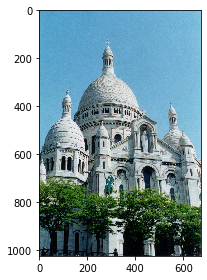

In [618]:
io.imshow(io.imread(qk))

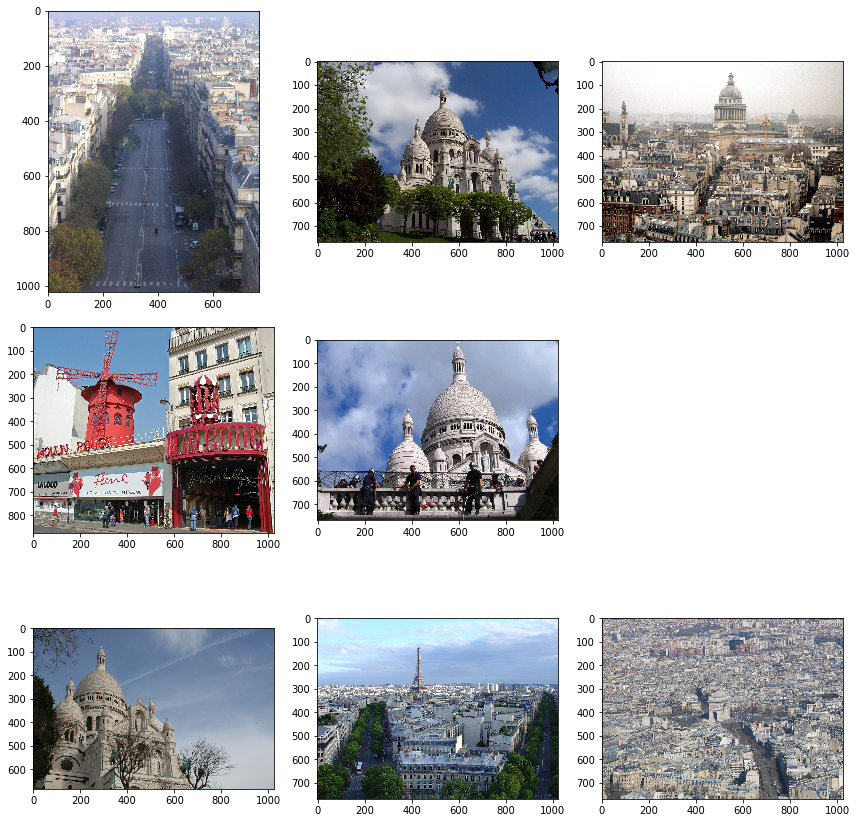

In [619]:
plt.subplots(3,3,figsize=(12,12))
for i,p in enumerate(result_paths):
    plt.subplot(3,3,i + 1)
    io.imshow(io.imread(p))
plt.show()